In [12]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
from scipy.optimize import least_squares
from autograd import jacobian

Base Classes

In [2]:
class Point():
    def __init__(self, x, y):
        """Defines a point using its physical space coordinates"""
        self.x = x
        self.y = y
        self.hc = self.get_hc()
    @classmethod
    def from_hc(cls, hc):
        """Defines a point from its representation in homogeneous coordinates"""
        if np.isclose(hc[2],0):
            x = hc[0]
            y = hc[1]
        else:
            x = hc[0] / hc[2]
            y = hc[1] / hc[2]
        return cls(x, y)
    def get_hc(self):
        """Returns the point in homogeneous coordinates"""
        return np.array([self.x, self.y, 1])
    def __repr__(self):
        """To string method for debugging"""
        return f"Point(x={self.x}, y={self.y}, hc={self.hc})"

In [3]:
class Homography():
    def __init__(self):
        pass
    def get_first_six_cols(self, x_points):
        zero_vec = np.zeros(3)
        eqn1_first6cols = np.vstack([np.hstack((point.hc, zero_vec)) for point in x_points])
        eqn2_first6cols = np.vstack([np.hstack((zero_vec, point.hc)) for point in x_points])
        return np.vstack([[eqn1, eqn2] for eqn1, eqn2 in zip(eqn1_first6cols, eqn2_first6cols)]) # Stack the rows in an interleaved fashion
        
    def estimate_projective_homography(self, x_points, x_prime_points):
        # Lets build the first 6 columns of the matrix we are interested in:
        first6cols = self.get_first_six_cols(x_points)
        
        # Now we only need the last 2 columns
        # x' is in the shape: x1' y1' 1, x2' y2' 1 etc
        # x is: x1 y1 1, x2 y2 1, ...
        # So we take the outer product of the first two elements in the homogeneous form to get the remaining portion:
        last2cols_list = []
        for x, x_prime in zip(x_prime_points, x_points):
            last2cols_list.append(-np.outer(x.get_hc()[:2], x_prime.get_hc()[:2]))
        last2cols = np.vstack(last2cols_list)
        full_matrix = np.hstack((first6cols, last2cols))
        
        x_prime_matrix = np.vstack([np.vstack((x_prime.hc[0], x_prime.hc[1])) for x_prime in x_prime_points])
        H = np.linalg.pinv(full_matrix) @ x_prime_matrix
        H = np.vstack((H, np.array(1))).reshape((3,3))
        return H

In [4]:
def get_SIFT_matching_points(img1_path, img2_path):
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    sift = cv2.SIFT_create()

    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher()

    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []

    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            keypoint1_coord = keypoints1[m.queryIdx].pt # (x,y) for img1
            keypoint2_coord = keypoints2[m.trainIdx].pt # (x,y) matches for img2
            good_matches.append((keypoint1_coord, keypoint2_coord))
    return good_matches


In [5]:
def print_SIFT_matches(img1_path, img2_path, match_list, output_img_path):
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    # Concatenate the images horizontally
    combined_image = np.hstack((img1, img2))

    for point_pair in match_list:
        # Point pair is a list of points [(x,y), (x,y), (x,y),..]
        point1 = (int(point_pair[0][0]), int(point_pair[0][1]))
        point2 = (int(point_pair[1][0]+img1.shape[1]), int(point_pair[1][1]))

        cv2.circle(combined_image, point1, radius=5, color=(0, 0, 255), thickness=-1)
        cv2.circle(combined_image, point2, radius=5, color=(255, 0, 0), thickness=-1)
    
        line_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        cv2.line(combined_image, point1, point2, color=line_color, thickness=2)
        
    cv2.imwrite(output_img_path, combined_image)

In [6]:
def print_RANSAC_matches(img1_path, img2_path, good_points, bad_points, output_img_path):
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    # Concatenate the images horizontally
    combined_image = np.hstack((img1, img2))
    
    for point_pair in good_points:
        # Point pair is a list of points [(x,y), (x,y), (x,y),..]
        point1 = (int(point_pair[0][0]), int(point_pair[0][1]))
        point2 = (int(point_pair[1][0]+img1.shape[1]), int(point_pair[1][1]))

        cv2.circle(combined_image, point1, radius=5, color=(0, 255, 0), thickness=-1)
        cv2.circle(combined_image, point2, radius=5, color=(0, 255, 0), thickness=-1)
    
        cv2.line(combined_image, point1, point2, color=(0, 255, 0), thickness=2)
        
    for point_pair in bad_points:
        # Point pair is a list of points [(x,y), (x,y), (x,y),..]
        point1 = (int(point_pair[0][0]), int(point_pair[0][1]))
        point2 = (int(point_pair[1][0]+img1.shape[1]), int(point_pair[1][1]))

        cv2.circle(combined_image, point1, radius=5, color=(0, 0, 255), thickness=-1)
        cv2.circle(combined_image, point2, radius=5, color=(0, 0, 255), thickness=-1)
    
        cv2.line(combined_image, point1, point2, color=(0, 0, 255), thickness=2)
        
    cv2.imwrite(output_img_path, combined_image)

In [7]:
def RANSAC_homography_estimation(sigma, match_list):
    num_samples = 4 # Number of points to randomly select during each trial
    p = 0.99 # probability that at least one trial has no outliers
    epsilon = 0.3 # probability that a random point is an outlier
    N = int(np.log(1-p)/np.log(1-(1-epsilon)**(num_samples))) # The number of trials required,
    delta = 3*sigma
    
    best_points = {"Inlier_Percent": -np.inf, "Points":[]} # Error Score, [((x11,y11), (x21,y21)), ((x12, y12), (x22, y22)), ...]
    
    # Go through N trials
    for trial_idx in range(N):
        # Sample 4 random matches from the list
        sampled_points = random.sample(match_list, k=num_samples)
        
        # Convert the points into HC format
        source_points = [Point(coordinate[0][0], coordinate[0][1]) for coordinate in sampled_points]
        target_points = [Point(coordinate[1][0], coordinate[1][1]) for coordinate in sampled_points]
        
        # Compute homography using the sampled points
        H = Homography().estimate_projective_homography(source_points, target_points)
        
        # Compute the matches to check error. Matches are computed for all interest points
        # We calculate the distance from the target_known_point to the estimated x_prime point for all interest points
        # We will keep the point with the highest percentage of inlier points
        inlier_count = 0
        inliers = []
        
        for source, target in match_list:
            # Get x and x'_true points in HC
            source = Point(source[0], source[1])
            target = Point(target[0], target[1])
            
            # Estimate x' using estimated homography
            x_prime = Point.from_hc(H@source.hc)
            
            # Calculate the estimation error using Euclidean distance
            error = np.linalg.norm(x_prime.hc - target.hc, ord=2)
            
            # Check if the estimate is an inlier
            if error < delta: 
                inlier_count += 1
                inliers.append((source, target))
        
        # Add the results to the dict
        if inlier_count/len(match_list) > best_points["Inlier_Percent"]:
            best_points["Inlier_Percent"] = inlier_count/len(match_list)
            best_points["Points"] = inliers
    
    return best_points["Inlier_Percent"], best_points["Points"]

In [8]:
class Panorama():
    def __init__(self, img_list, homography_list):
        self.img_list = img_list
        self.homography_list = homography_list
        
        # Calculate the output size using the image corners
        # We then return an empty image of the correct shape to fit all points
        panorama_image, C_pn = self.find_corner_points()
        
        # Plot the corners from the image to make sure it is correct
        self.plot_corners(panorama_image, C_pn)
        
        # Fill the color into the panoramage canvas
        self.panorama_img = self.generate_output(panorama_image, C_pn)
        
    def get_image_results(self):
        return self.panorama_img
        
    def find_corner_points(self):
        corner_mats = np.zeros((len(self.img_list), 3, 4))
        for i, img in enumerate(self.img_list):
            # Creates a matrix of shape [3,4] where each entry is the hc coordinate of a corner point
            # Points are (x,y,1)
            corner_mats[i] = np.array((Point(0,0).hc, Point(img.shape[1], 0).hc, Point(img.shape[1], img.shape[0]).hc, Point(0, img.shape[0]).hc)).T
        
        C_prime = np.zeros((len(self.img_list), 3, 4))
        for i in range(len(self.img_list)):
            C_prime[i] = self.homography_list[i]@corner_mats[i]
        
        # Corner points are still (x,y,1)
        C_pn = C_prime / (C_prime[:, 2, :][:, np.newaxis, :] + 1e-6)
        x_min, y_min, x_max, y_max = np.min(C_pn[:, 0, :]), np.min(C_pn[:, 1, :]), np.max(C_pn[:, 0, :]), np.max(C_pn[:, 1, :])
        
        # Make the points into integers for image processing
        x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
        
        background_space = np.zeros((y_max-y_min, x_max-x_min, 3), dtype=np.uint8)
        return background_space, C_pn
    
    def transform_image(self, hc_coords, homography):
        # hc_coords is a meshgrid of the panorama image
        H_inv = np.linalg.inv(homography)

        # Get normalized warped HC
        src_hc_coords = (H_inv @ hc_coords.T).T
        src_hc_coords = src_hc_coords / (src_hc_coords[:, 2][:, np.newaxis] + 1e-6)
        return src_hc_coords
    
    def plot_corners(self, panorama_image, C_pn):
        C_pn_translated = np.zeros_like(C_pn)
        C_pn_translated[:, 0, :] = C_pn[:, 0, :] - np.min(C_pn[:, 0, :])
        C_pn_translated[:, 1, :] = C_pn[:, 1, :] - np.min(C_pn[:, 1, :])
        
        # Take out just the x,y points
        points = C_pn_translated[:, :2, :]
        # Convert the list of points so that the output is [[y1, x1], [y2,x2], [y3,x3]] instead of them being split
        # accross multiple rows and within a batch of images.
        points = np.hstack(points)
        points = np.column_stack((points[0], points[1]))
        
        y_vals, x_vals = points[:, 0], points[:, 1]
        
        # Fill in the corner points into the panorama image:
        fig, ax = plt.subplots()
        ax.imshow(panorama_image)
        
        # point_idx = self.get_point_ordering_for_corner_printing(len(y_vals))
        # print(point_idx)
        # for i in range(0, len(point_idx), 4):
        for i in range(0, len(y_vals), 4):
            # Get a random color to fill in the polygon
            color = [[random.randint(0, 255)/255, random.randint(0, 255)/255, random.randint(0, 255)/255]]
            
            points = [[y_vals[i],x_vals[i]], [y_vals[i+1],x_vals[i+1]], [y_vals[i+2],x_vals[i+2]], [y_vals[i+3],x_vals[i+3]]]
            polygon = patches.Polygon(points, closed=True, color=color[0], fill=False, linewidth=2)
            ax.add_patch(polygon)
            
        plt.savefig("corners.jpg")

    def generate_output(self, panorama_image, C_pn):
        # Offset to subtract to points in images to bring the corners within the final image coordinate frame
        x_min = np.min(C_pn[:, 0, :])
        y_min = np.min(C_pn[:, 1, :])
        
        h, w, c = panorama_image.shape
        panorama_image = panorama_image.reshape(-1, 3)
    
        # Create pixel coordinate grid for the target image (y, x) -> (x,y)
        y_range, x_range = np.arange(h), np.arange(w)
        y_range = y_range + y_min
        x_range = x_range + x_min
        x_1, x_2 = np.meshgrid(x_range, y_range) # Now we have (x, y)
        
        # Flatten the grid and create homogeneous coordinates (x, y)
        real_coords = np.vstack([x_1.ravel(), x_2.ravel()]).T
        ones_column = np.ones((real_coords.shape[0], 1))
        panorama_hc_coords = np.hstack((real_coords, ones_column))  # Homogeneous coordinates
        
        for homography, img in zip(self.homography_list, self.img_list):
            img_h, img_w, img_c = img.shape
            
            # Get the panorama image in terms of img1's coordinate frame
            warped_img_hc = self.transform_image(panorama_hc_coords, homography)
            img_points = warped_img_hc[:, :2]
            
            # Apply offset to bring all the points to the translated (0,0) based frame
            src_x = img_points[:, 0]
            src_y = img_points[:, 1]
            
            valid_mask = (src_x >= 0) & (src_x < img.shape[1]) & (src_y >= 0) & (src_y < img.shape[0])
            valid_x = src_x[valid_mask].astype(int)
            valid_y = src_y[valid_mask].astype(int)
            idx = valid_y * img_w + valid_x
            
            img = img.reshape(-1, 3)
            panorama_image[valid_mask] = img[idx]
            
        panorama_image = panorama_image.reshape(h,w,c)
        
        return panorama_image

Calling Code

In [9]:
input_prefix = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW5/pics/"
output_prefix = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW5/Output_Pics/"
keys = ["fountain_", "climb_"]
k = 0.05
sigma = 1.2
h_out = 600 # The height of the output image for scaling

RANSAC with Linear Least Squares

In [11]:
for key in keys: 
    image_names = [key+str(i+1)+".jpg" for i in range(5)]
    
    image_homographies = []
    img_list = []
    for i in range(4):
        # I want the homographies for: 0->1->2 and 4->3->2
        if i < 2:
            # 0->1->2 
            img1_path = input_prefix+image_names[i]
            img2_path = input_prefix+image_names[i+1]
        elif i==2:
            # All images are mapped to the middle image so we don't need to compute the homography from 2->2
            image_homographies.append(np.eye(3))
            
            # at i=2, we add the Identity matrix, then also get img 4->3
            img1_path = input_prefix+image_names[i+1]
            img2_path = input_prefix+image_names[i]
        else:
            # 4<-5
            img1_path = input_prefix+image_names[i+1]
            img2_path = input_prefix+image_names[i]
            
        # Get matching points for pairs of images
        match_list = get_SIFT_matching_points(img1_path, img2_path)
        
        # Save keypoint matches to a file
        # print_SIFT_matches(img1_path, img2_path, match_list, output_prefix+"SIFT_Matches/"+key+str(i)+"_"+str(i+1)+".jpg") 
        
        # Apply RANSAC to get the largest set of inliers:
        inlier_percent, best_points = RANSAC_homography_estimation(sigma, match_list)
        match_set = set(match_list)
        best_point_xy = []
        for point_pair in best_points:
            point1 = (point_pair[0].hc[0], point_pair[0].hc[1])
            point2 = (point_pair[1].hc[0], point_pair[1].hc[1])
            best_point_xy.append((point1, point2))
            
        best_point_set = set(best_point_xy)
        bad_points_set = match_set - best_point_set
        
        print_RANSAC_matches(img1_path, img2_path, best_point_set, bad_points_set, output_prefix+"RANSAC/"+key+str(i)+"_"+str(i+1)+".jpg") 
        
        # Get points for homography estimates
        source = [point_pair[0] for point_pair in best_points]
        target = [point_pair[1] for point_pair in best_points]
        
        # Compute homographies for those point pairs
        homography = Homography().estimate_projective_homography(source, target)
        
        # Homographies will be in the following order: h_12, h_23, I, h_43, h_54
        image_homographies.append(homography)

    for image_name in image_names:
        img_list.append(np.array(Image.open(input_prefix+image_name)))
    
    # Map the homographies to the center image
    homography_list = []
    homography_list.append(image_homographies[1]@image_homographies[0])
    homography_list.append(image_homographies[1])
    homography_list.append(image_homographies[2])
    homography_list.append(image_homographies[3])
    homography_list.append(image_homographies[4]@image_homographies[3])
    
    # panorama_img = Panorama(img_list=img_list, homography_list=homography_list).get_image_results()
    # panorama_img = cv2.cvtColor(panorama_img, cv2.COLOR_RGB2BGR)
    # cv2.imwrite(output_prefix+"Least_Squares/"+image_name[:-5]+"pano.jpg", panorama_img)


RANSAC with scipy LM

In [10]:
def cost_func(h, inliers):
    # h has the form [h11, h12, h13, h21, h22, h23, h31, h32, h33]
    # We want to minimize ||X - f(p)||^2
    target_points = inliers[:, 1]
    
    x_hat = inliers[:, 0, 0]
    y_hat = inliers[:, 0, 1]
    
    divisor = x_hat*h[6] + y_hat*h[7] + h[8]
    x_prime = (x_hat*h[0] + y_hat*h[1] + h[2])/divisor
    y_prime = (x_hat*h[3] + y_hat*h[4] + h[5])/divisor

    # Shape is (n, 2) with x,y horizontally collated together [[x1,y1], [x2,y2], ...]
    F = np.vstack((x_prime, y_prime)).T
    return (target_points - F).ravel()

In [13]:
for key in keys: 
    image_names = [key+str(i+1)+".jpg" for i in range(5)]
    
    image_homographies = []
    img_list = []
    for i in range(4):
        # I want the homographies for: 0->1->2 and 4->3->2
        if i < 2:
            # 0->1->2 
            img1_path = input_prefix+image_names[i]
            img2_path = input_prefix+image_names[i+1]
        elif i==2:
            # All images are mapped to the middle image so we don't need to compute the homography from 2->2
            image_homographies.append(np.eye(3))
            
            # at i=2, we add the Identity matrix, then also get img 4->3
            img1_path = input_prefix+image_names[i+1]
            img2_path = input_prefix+image_names[i]
        else:
            # 4<-5
            img1_path = input_prefix+image_names[i+1]
            img2_path = input_prefix+image_names[i]
            
        # Get matching points for pairs of images
        match_list = get_SIFT_matching_points(img1_path, img2_path)
        
        # Save keypoint matches to a file
        # print_SIFT_matches(img1_path, img2_path, match_list, output_prefix+"SIFT_Matches/"+key+str(i)+"_"+str(i+1)+".jpg") 
        
        # Apply RANSAC to get the largest set of inliers:
        inlier_percent, best_points = RANSAC_homography_estimation(sigma, match_list)
        match_set = set(match_list)
        best_point_xy = []
        for point_pair in best_points:
            point1 = (point_pair[0].hc[0], point_pair[0].hc[1])
            point2 = (point_pair[1].hc[0], point_pair[1].hc[1])
            best_point_xy.append((point1, point2))
            
        best_point_set = set(best_point_xy)
        bad_points_set = match_set - best_point_set
        
        # Print the inliers & outliers from ransac
        # print_RANSAC_matches(img1_path, img2_path, best_point_set, bad_points_set, output_prefix+"RANSAC/"+key+str(i)+"_"+str(i+1)+".jpg") 
        
        # Get points for homography estimates
        source = [point_pair[0] for point_pair in best_points]
        target = [point_pair[1] for point_pair in best_points]
        
        # Compute homographies for those point pairs
        homography = Homography().estimate_projective_homography(source, target)
        
        # Apply Levenberg-Marquadt
        # Transform the homography into a 1,9 tensor
        optimal_homography = homography.flatten()
        inliers = np.array(best_point_xy)
        optimal_homography = least_squares(cost_func, optimal_homography, args=(inliers,), method='lm')
        optimal_homography = optimal_homography.x.reshape((3,3))
        
        # Homographies will be in the following order: h_12, h_23, I, h_43, h_54
        # We need to unpack the homography from the optimizedResult object by getting the x value
        image_homographies.append(optimal_homography)

    for image_name in image_names:
        img_list.append(np.array(Image.open(input_prefix+image_name)))
    
    # Map the homographies to the center image
    homography_list = []
    homography_list.append(image_homographies[1]@image_homographies[0])
    homography_list.append(image_homographies[1])
    homography_list.append(image_homographies[2])
    homography_list.append(image_homographies[3])
    homography_list.append(image_homographies[4]@image_homographies[3])
    
    
    panorama_img = Panorama(img_list=img_list, homography_list=homography_list).get_image_results()
    panorama_img = cv2.cvtColor(panorama_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_prefix+"Scipy_LM/"+image_name[:-5]+"pano.jpg", panorama_img)


My own LM implementation based on the provided pseudo-code

In [92]:
def calculate_jacobian(cost_func, h, inliers):
    # We are going to approximate the derivates by adding a small pertubation to see how that affects the cost function
    # So: we add a very small value to each component of h and compute the change vector and add that into the jacobian matrix.
    homography = h.flatten()
    residuals = cost_func(homography, inliers)
    
    # Jacobian matrix will have n cols and m rows:
    # [[df1/dp1 ----- df1/dpn], ........, [dfm/dp1, ------, dfm/dpm]]
    J = np.zeros((len(residuals), len(homography)))
    epsilon = 1e-6
    
    for h_idx in range(len(homography)):
        h_cpy = np.copy(homography)
        h_cpy[h_idx] += epsilon
    
        perturbed_residuals = cost_func(h_cpy, inliers)
        
        J[:, h_idx] = (perturbed_residuals - residuals)/epsilon
    return J

In [93]:
def levenberg_marquadt(cost_func, opt_H, inliers):
    # Cost function for printing results:
    cost_values = []
    
    # Constants:
    k = 0
    v = 2
    tau = 1e-3
    epsilon_1, epsilon_2, epsilon_3 = 1e-15, 1e-15, 1e-15
    kmax = 100
    
    p = opt_H.flatten()
    J = calculate_jacobian(cost_func, p, inliers)
    A = J.T@J
    epsilon = cost_func(p, inliers)
    cost_values.append(epsilon)
    g = J.T@epsilon

    rho = -np.inf    
    stop = np.linalg.norm(g, np.inf) < epsilon_1
    mu = tau * np.max(np.diagonal(A))
    
    while not stop and k < kmax:
        k=k+1
        while (rho <= 0) and (not stop):
            delta_p = np.linalg.pinv(A+mu*np.eye(9)) @ g
            if np.linalg.norm(delta_p, ord=1) <= epsilon_2* np.linalg.norm(p, ord=1):
                stop = True
            else:
                p_new = p + delta_p
                rho_numerator = np.linalg.norm(epsilon, ord=2)**2 - np.linalg.norm(cost_func(p_new, inliers), ord=2)**2
                rho_denominator = delta_p.T @ (mu * delta_p + g)
                rho = rho_numerator / rho_denominator
                
                if rho > 0:
                    p = p_new
                    J = calculate_jacobian(cost_func, p, inliers)
                    A = J.T@J
                    epsilon = cost_func(p, inliers)
                    cost_values.append(epsilon)
                    
                    g = J.T@epsilon
                    stop = np.linalg.norm(g, np.inf) < epsilon_1 or np.linalg.norm(epsilon, ord=2) <= epsilon_3
                    mu = mu * np.max((1/3, 1-(2*rho-1)**3))
                    v = 2
                else:
                    mu = mu * v
                    v = 2 * v
    return p, cost_values

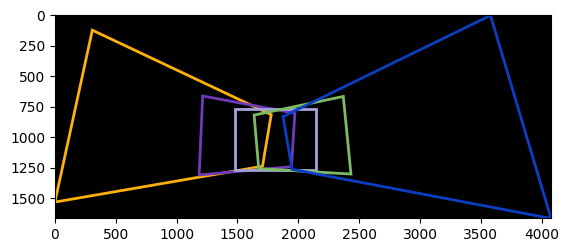

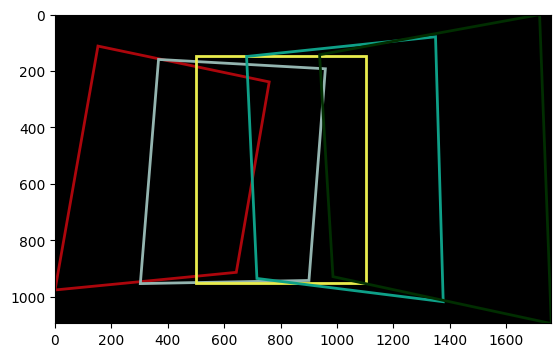

In [94]:
cost_values_all = []
for key in keys: 
    image_names = [key+str(i+1)+".jpg" for i in range(5)]
    
    cost_values_key = []
    image_homographies = []
    img_list = []
    for i in range(4):
        # I want the homographies for: 0->1->2 and 4->3->2
        if i < 2:
            # 0->1->2 
            img1_path = input_prefix+image_names[i]
            img2_path = input_prefix+image_names[i+1]
        elif i==2:
            # All images are mapped to the middle image so we don't need to compute the homography from 2->2
            image_homographies.append(np.eye(3))
            
            # at i=2, we add the Identity matrix, then also get img 4->3
            img1_path = input_prefix+image_names[i+1]
            img2_path = input_prefix+image_names[i]
        else:
            # 4<-5
            img1_path = input_prefix+image_names[i+1]
            img2_path = input_prefix+image_names[i]
            
        # Get matching points for pairs of images
        match_list = get_SIFT_matching_points(img1_path, img2_path)
        
        # Save keypoint matches to a file
        # print_SIFT_matches(img1_path, img2_path, match_list, output_prefix+"SIFT_Matches/"+key+str(i)+"_"+str(i+1)+".jpg") 
        
        # Apply RANSAC to get the largest set of inliers:
        inlier_percent, best_points = RANSAC_homography_estimation(sigma, match_list)
        match_set = set(match_list)
        best_point_xy = []
        for point_pair in best_points:
            point1 = (point_pair[0].hc[0], point_pair[0].hc[1])
            point2 = (point_pair[1].hc[0], point_pair[1].hc[1])
            best_point_xy.append((point1, point2))
            
        best_point_set = set(best_point_xy)
        bad_points_set = match_set - best_point_set
        
        # Print the inliers & outliers from ransac
        # print_RANSAC_matches(img1_path, img2_path, best_point_set, bad_points_set, output_prefix+"RANSAC/"+key+str(i)+"_"+str(i+1)+".jpg") 
        
        # Get points for homography estimates
        source = [point_pair[0] for point_pair in best_points]
        target = [point_pair[1] for point_pair in best_points]
        
        # Compute homographies for those point pairs
        homography = Homography().estimate_projective_homography(source, target)
        
        # Apply Levenberg-Marquadt
        # Transform the homography into a 1,9 tensor
        optimal_homography = homography.flatten()
        inliers = np.array(best_point_xy)
        optimal_homography, cost_results = levenberg_marquadt(cost_func, optimal_homography, inliers)
        cost_values_key.append(cost_results)
        optimal_homography = optimal_homography.reshape((3,3))
        
        # Homographies will be in the following order: h_12, h_23, I, h_43, h_54
        # We need to unpack the homography from the optimizedResult object by getting the x value
        image_homographies.append(optimal_homography)
    cost_values_all.append(cost_values_key)
    
    
    for image_name in image_names:
        img_list.append(np.array(Image.open(input_prefix+image_name)))
    
    # Map the homographies to the center image
    homography_list = []
    homography_list.append(image_homographies[1]@image_homographies[0])
    homography_list.append(image_homographies[1])
    homography_list.append(image_homographies[2])
    homography_list.append(image_homographies[3])
    homography_list.append(image_homographies[4]@image_homographies[3])
    
    
    panorama_img = Panorama(img_list=img_list, homography_list=homography_list).get_image_results()
    panorama_img = cv2.cvtColor(panorama_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_prefix+"LM/"+image_name[:-5]+"pano.jpg", panorama_img)


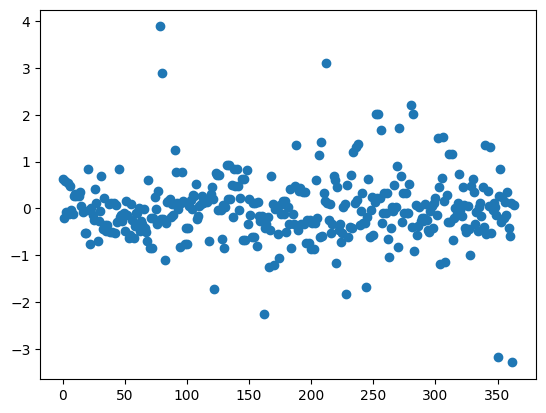

In [89]:
key = 1
pair = 3
data = cost_values_all[key][pair][0]
x = range(len(data))
plt.scatter(x, data)
plt.show()